C:\Users\HP\AppData\Local\Temp\ipykernel_10712\4072651366.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time)
C:\Users\HP\AppData\Local\Temp\ipykernel_10712\4072651366.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time)
C:\Users\HP\AppData\Local\Temp\ipykernel_10712\4072651366.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time)
C:\Users\HP\AppData\Local\Temp\ipykernel_10712\4072651366.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time)
C:\Users\HP\AppData\Local\Temp\ipykernel_10712\4072651366.py:112: DeprecationWarning: `t

Reliable temps   : [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Unreliable temps : [45]


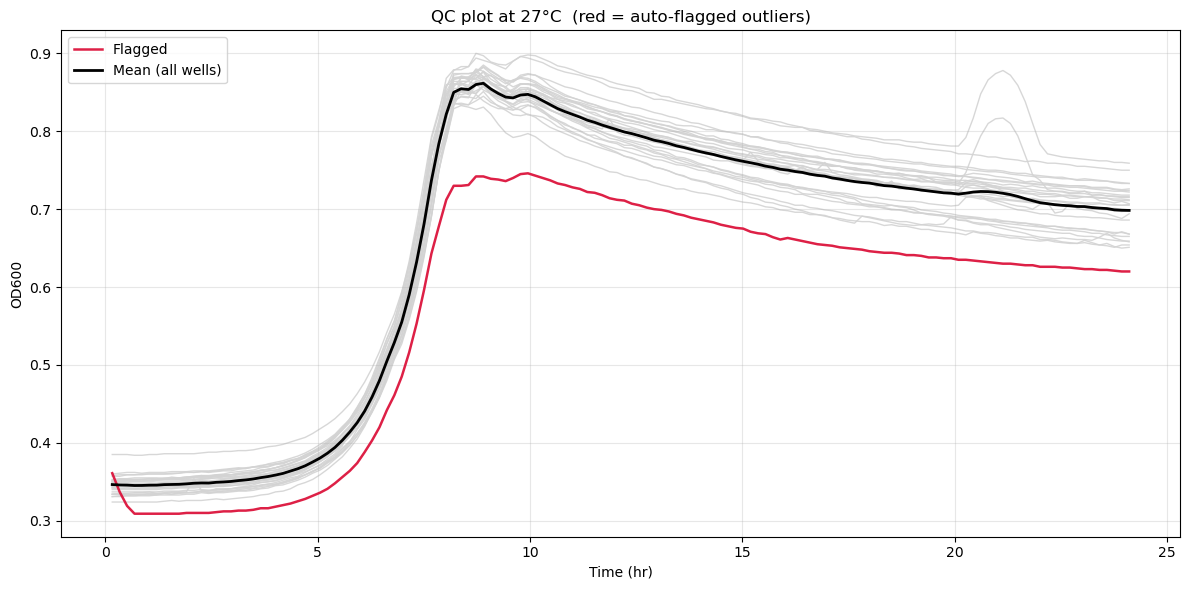

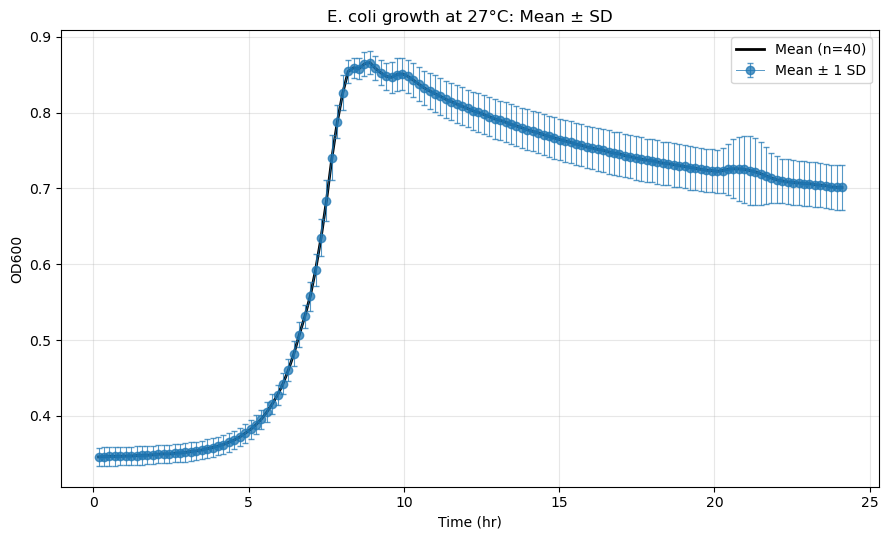

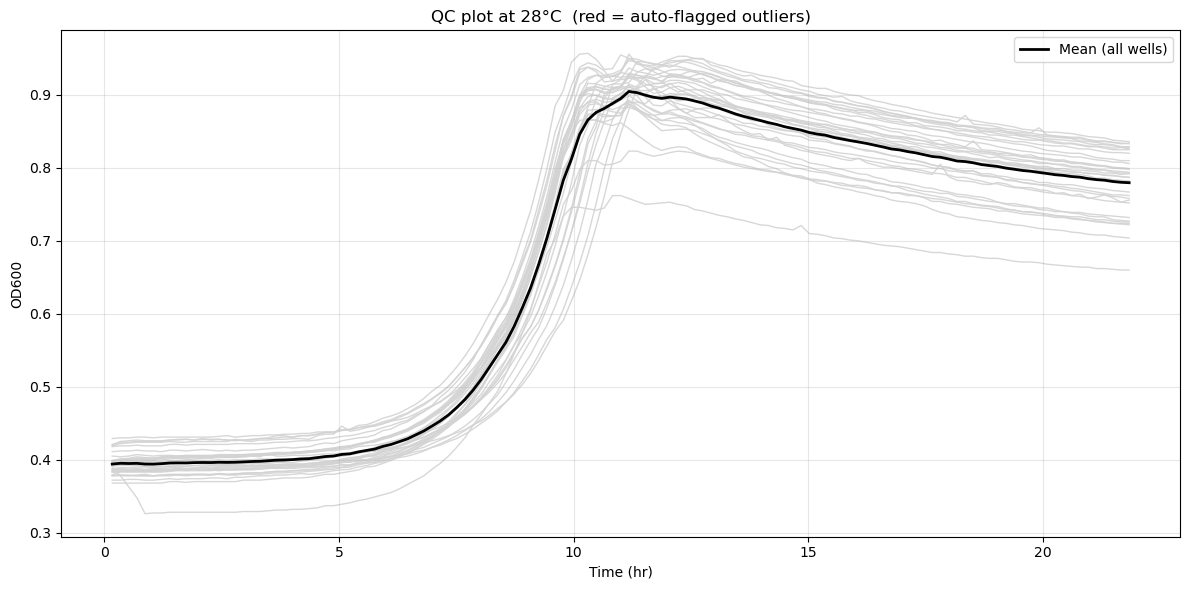

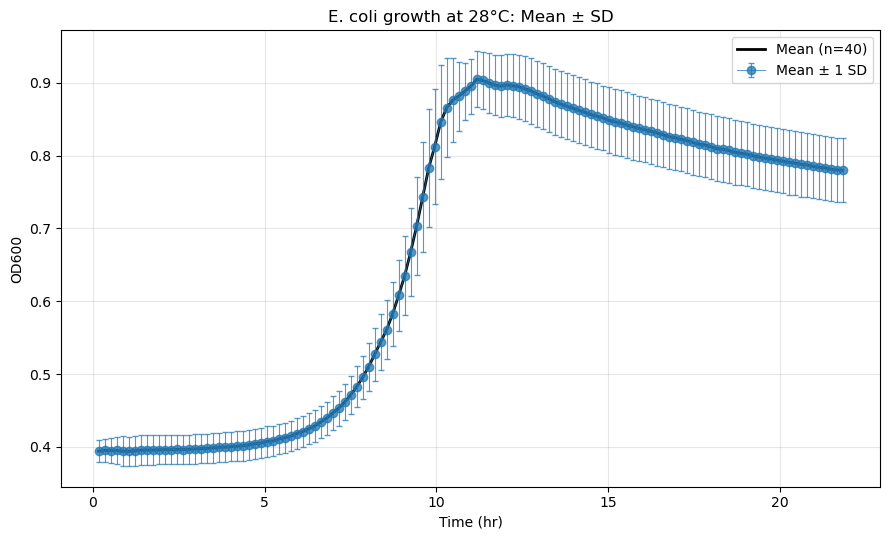

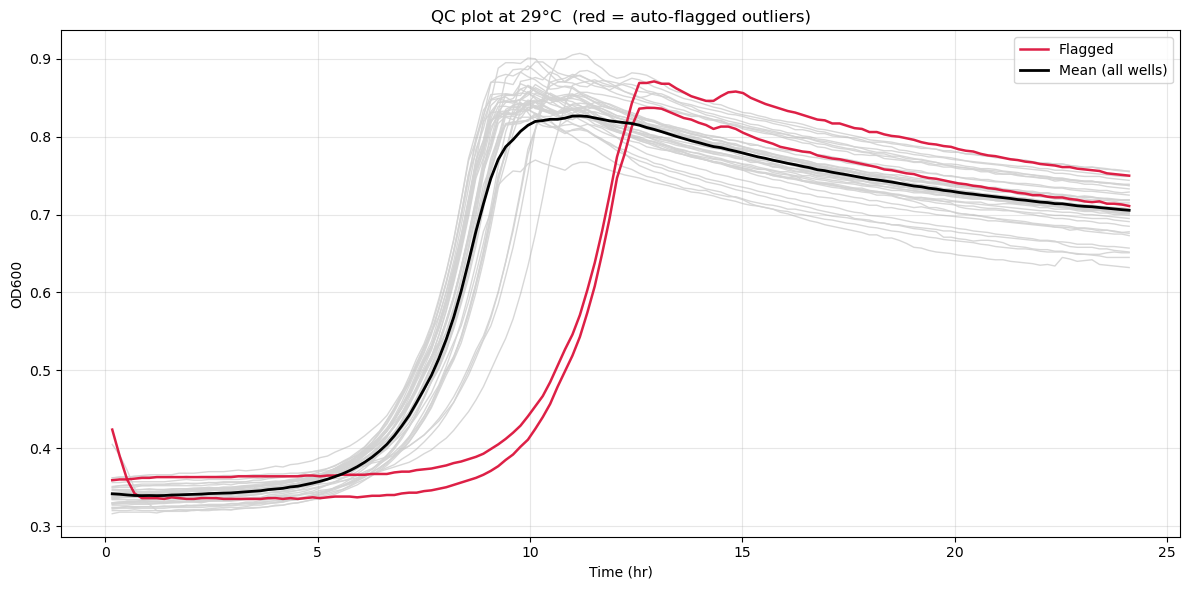

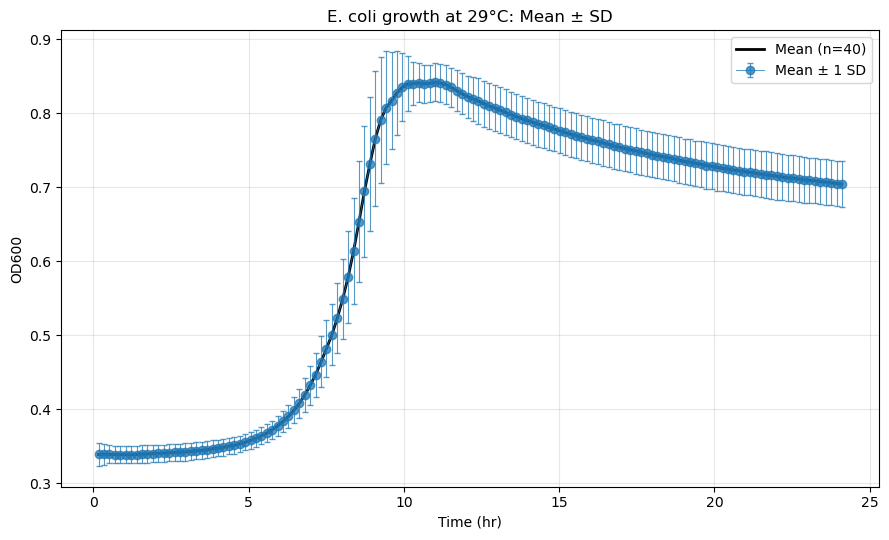

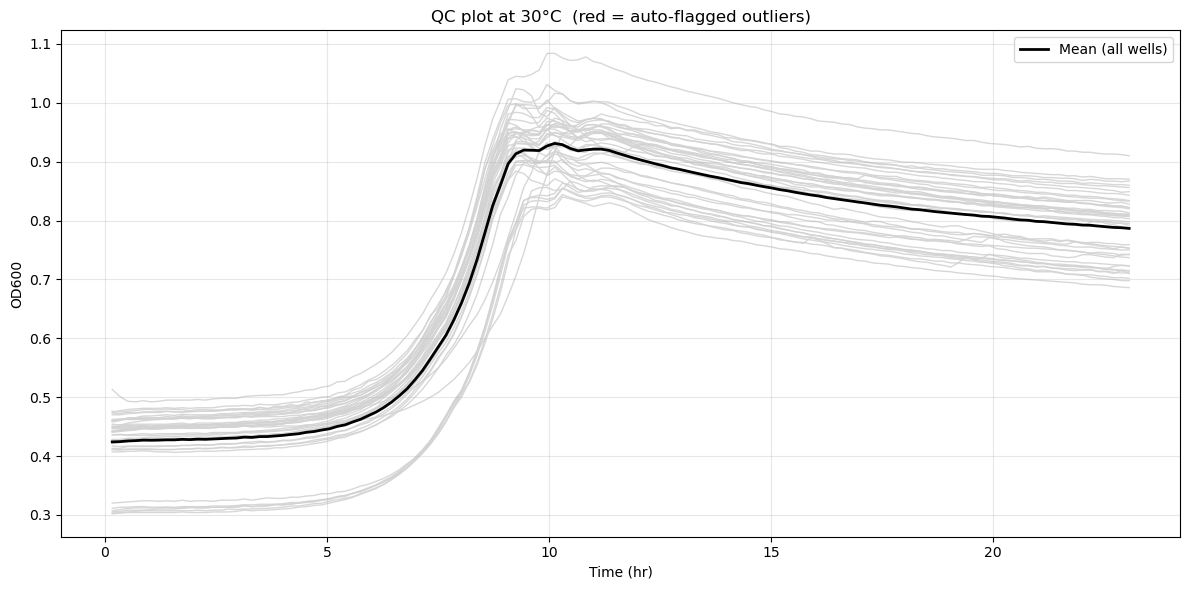

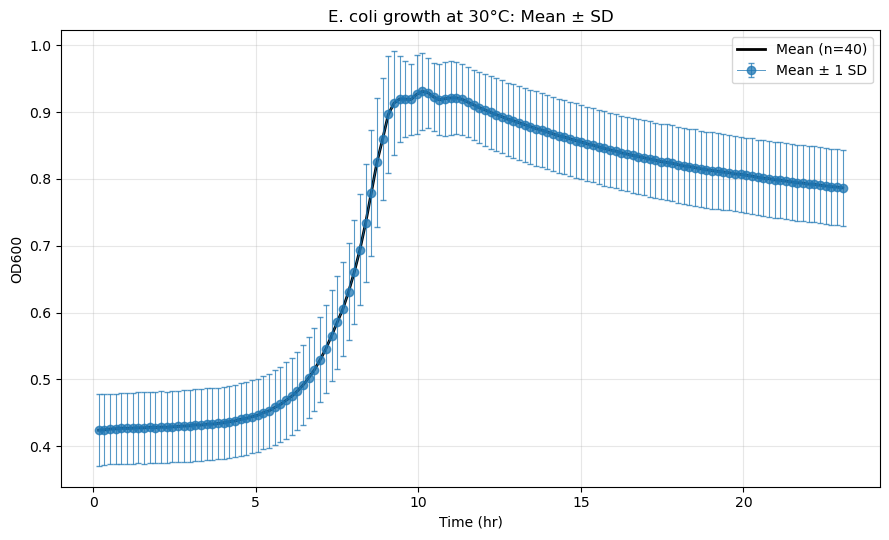

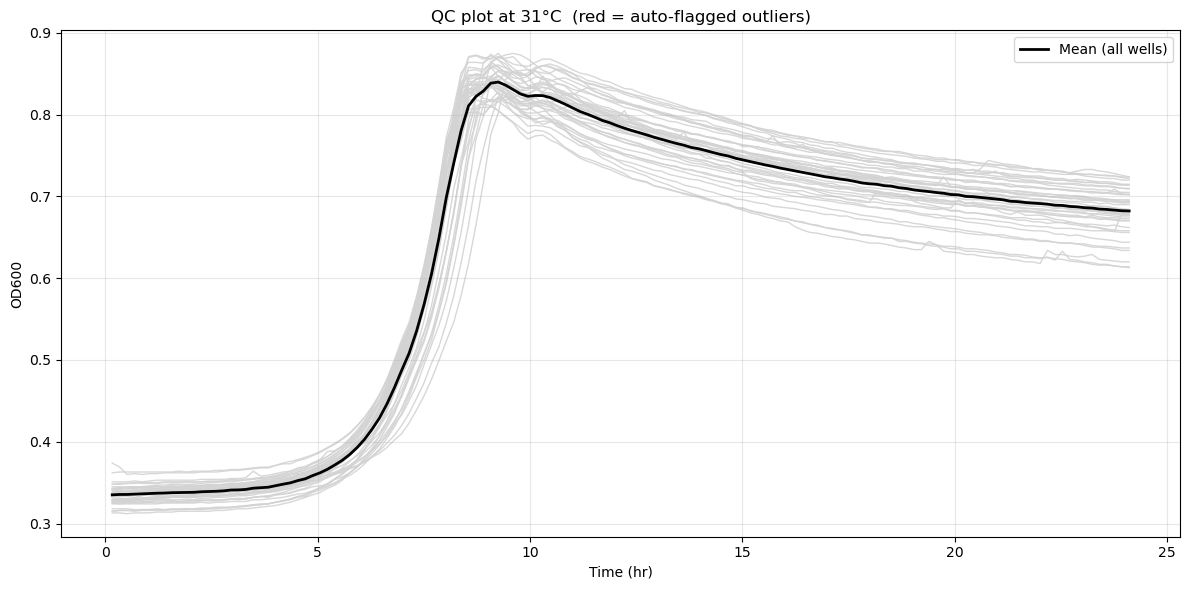

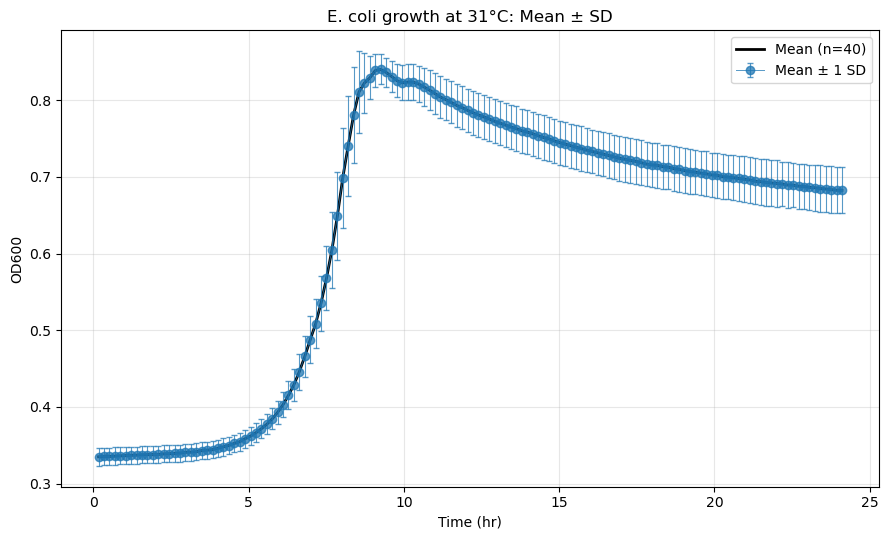

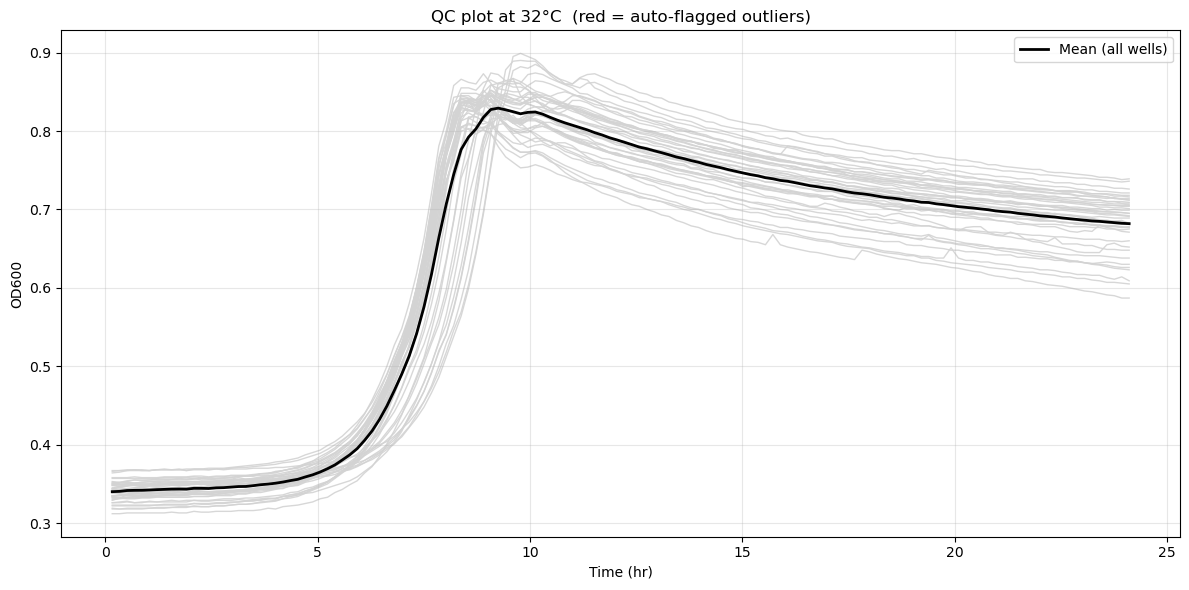

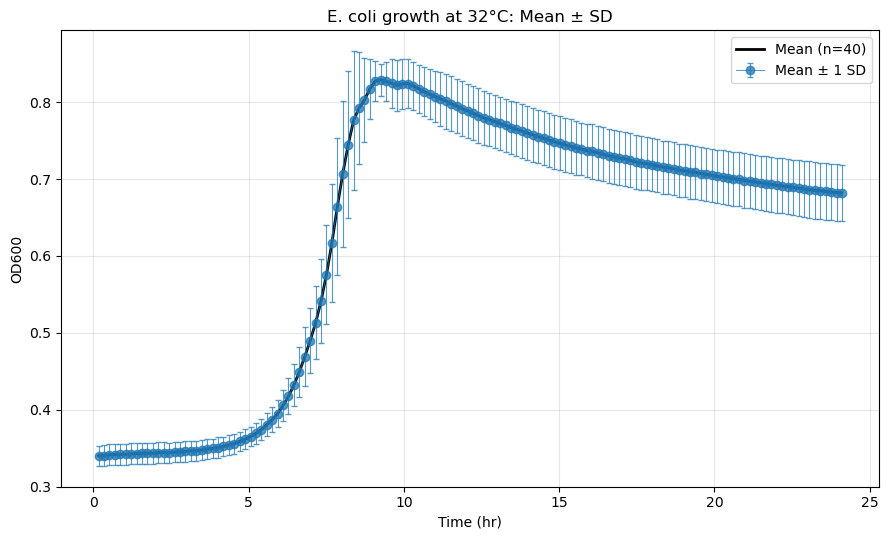

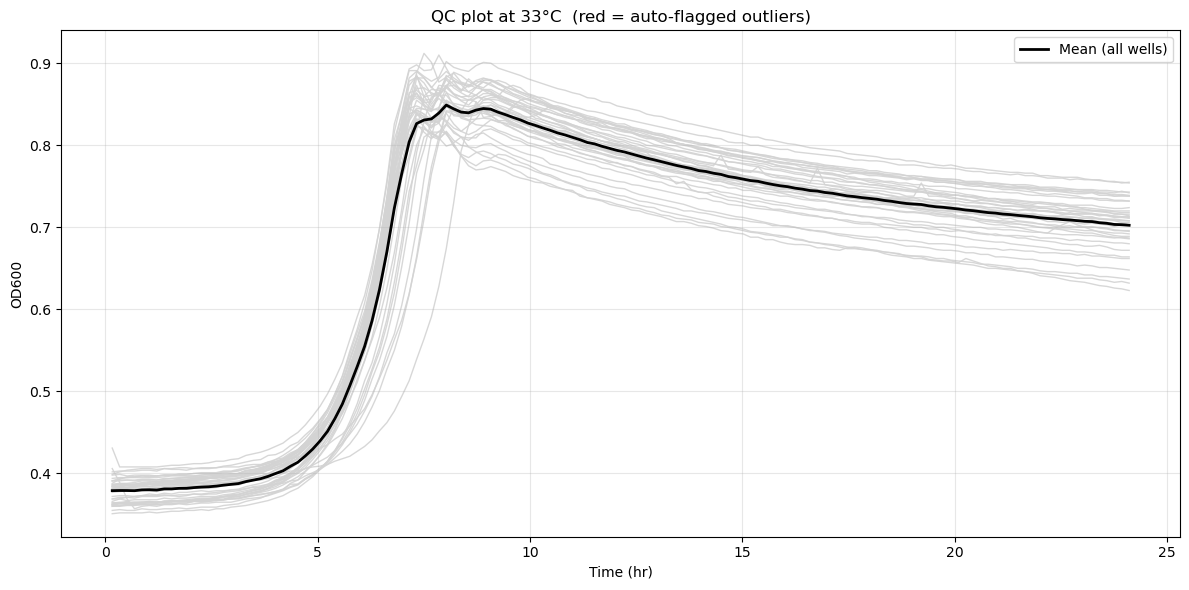

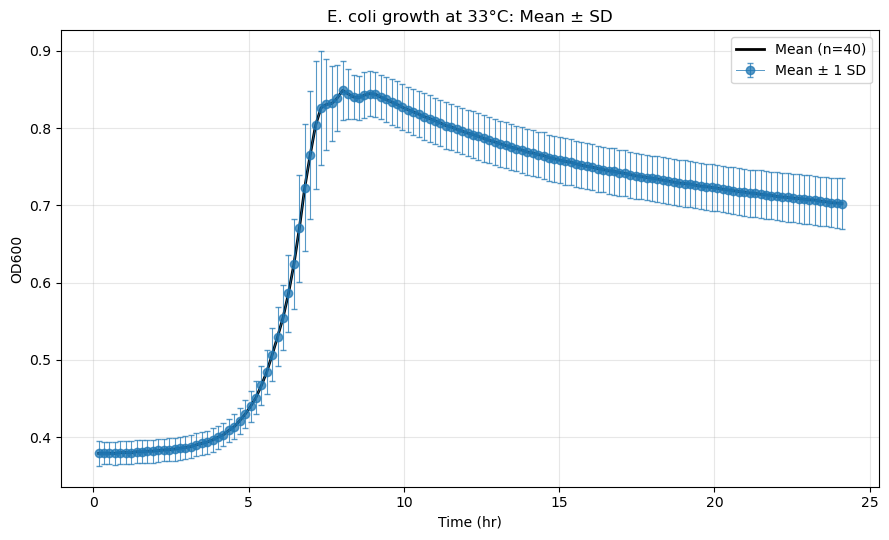

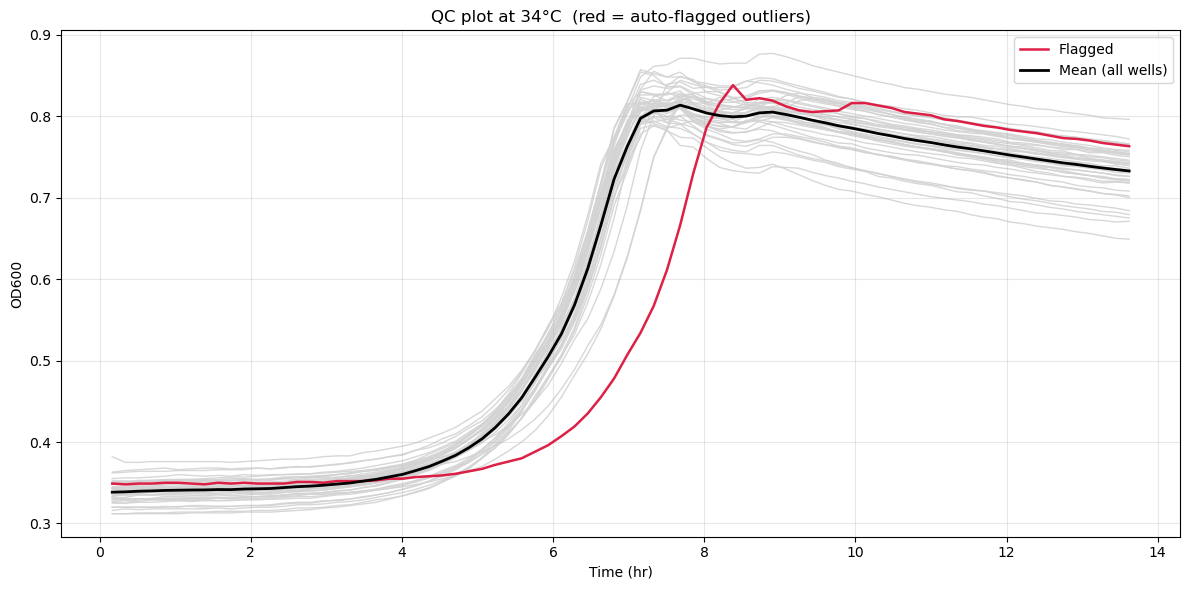

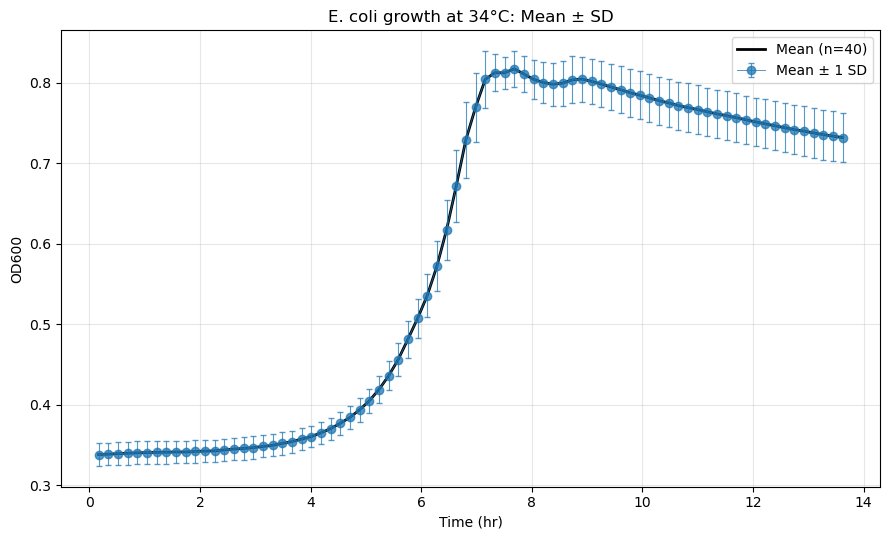

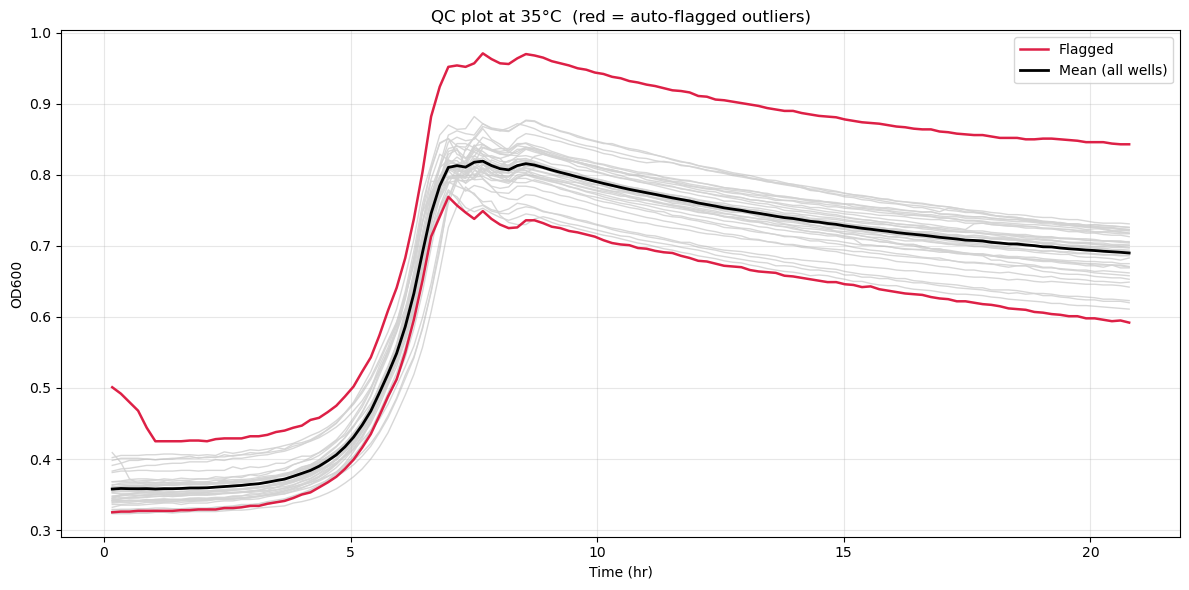

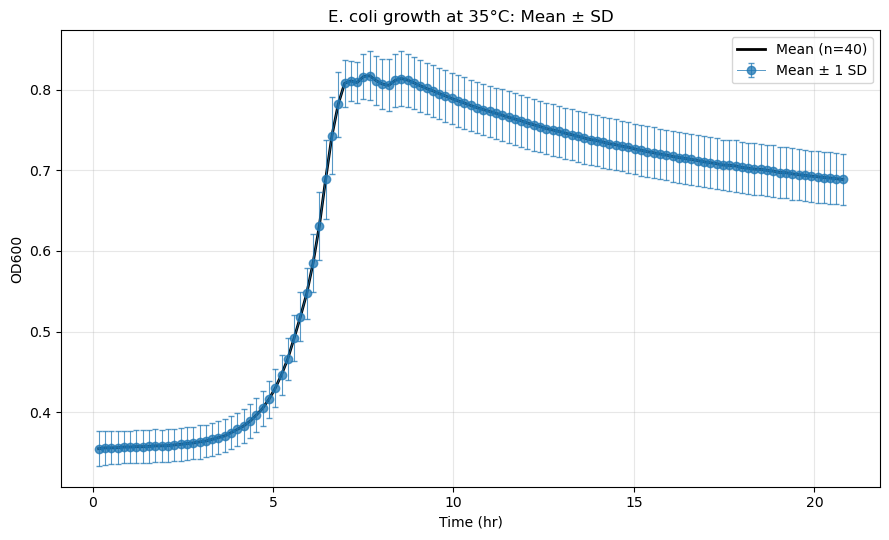

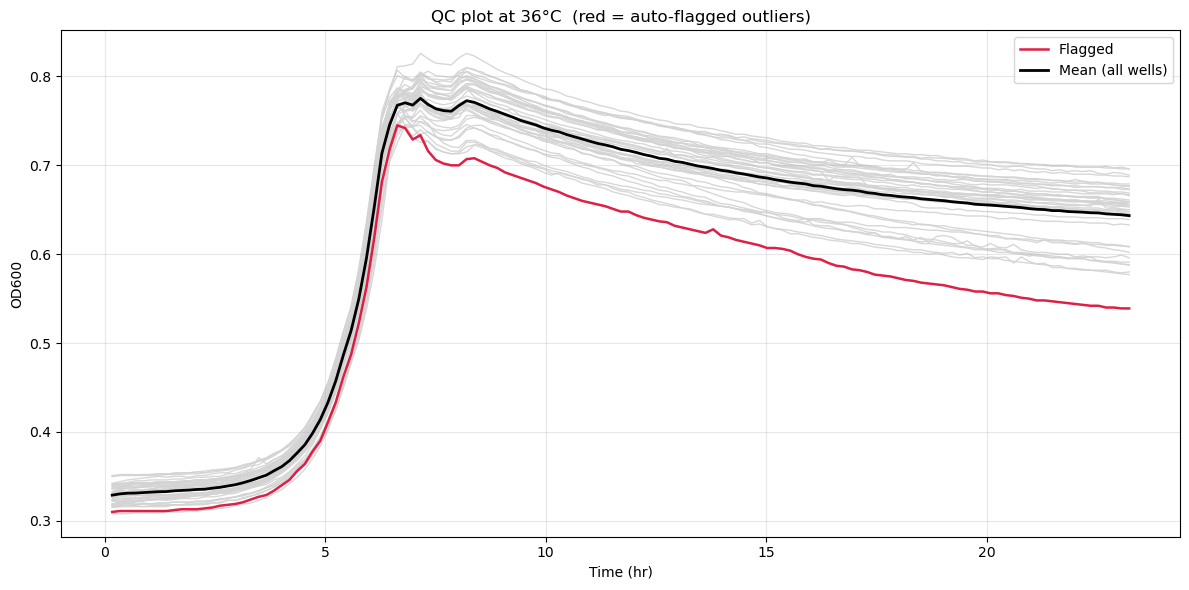

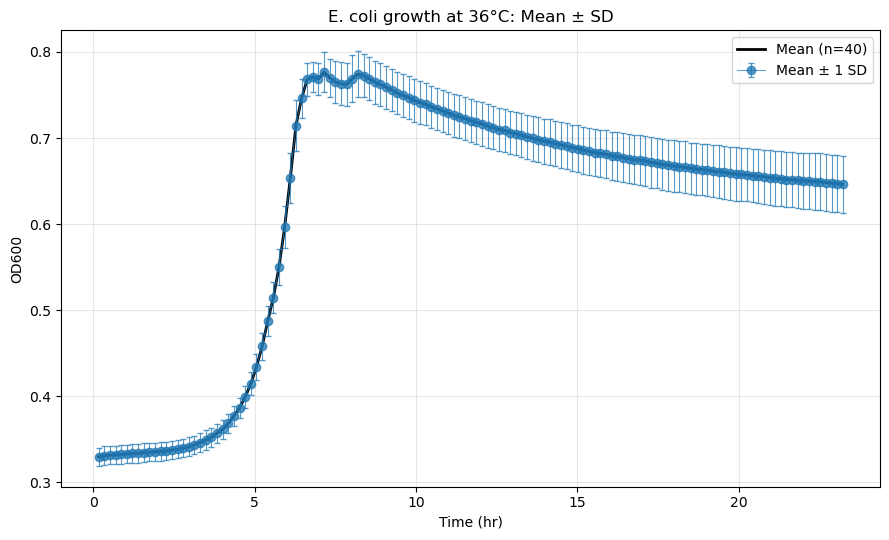

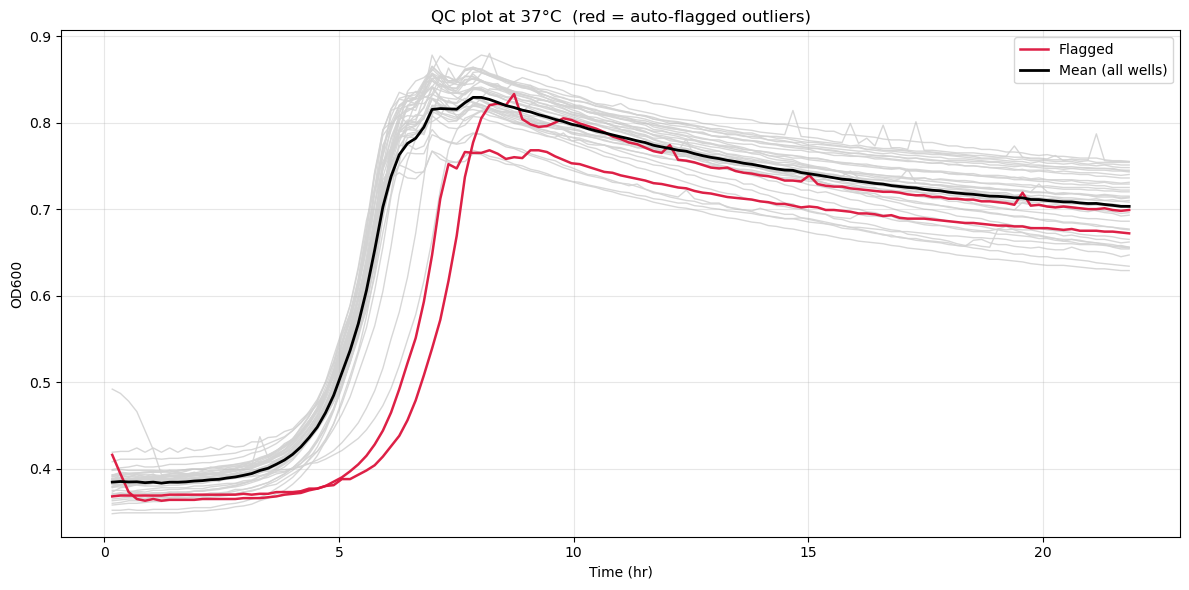

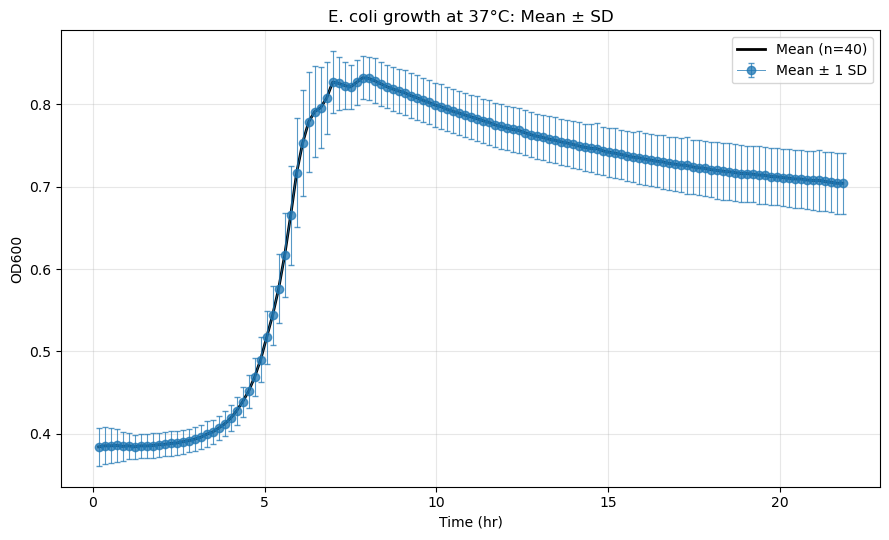

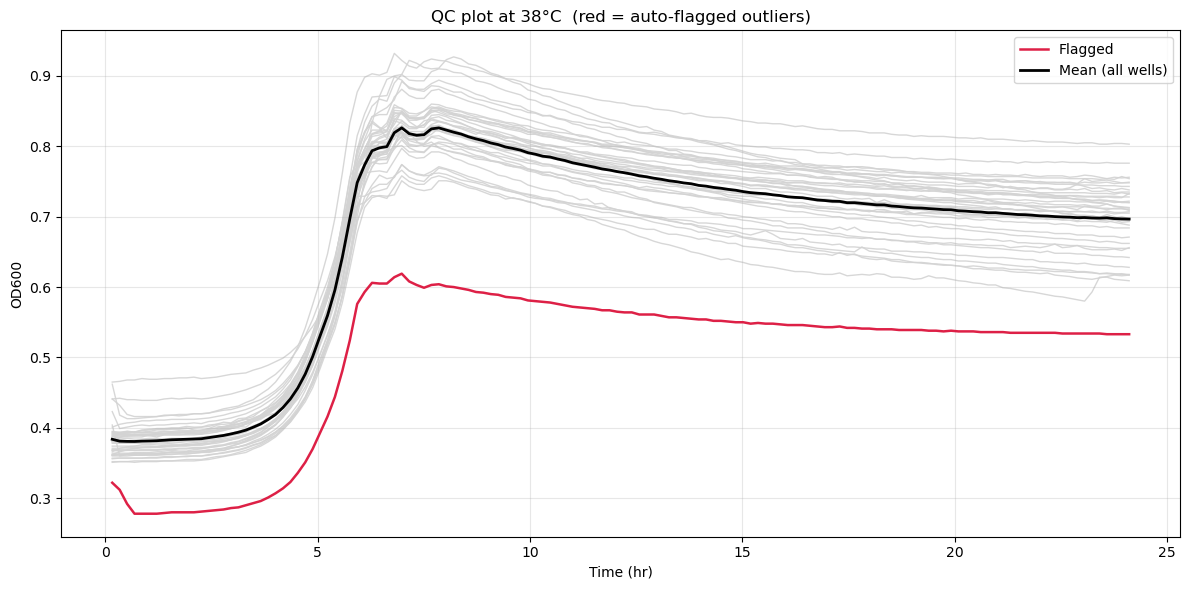

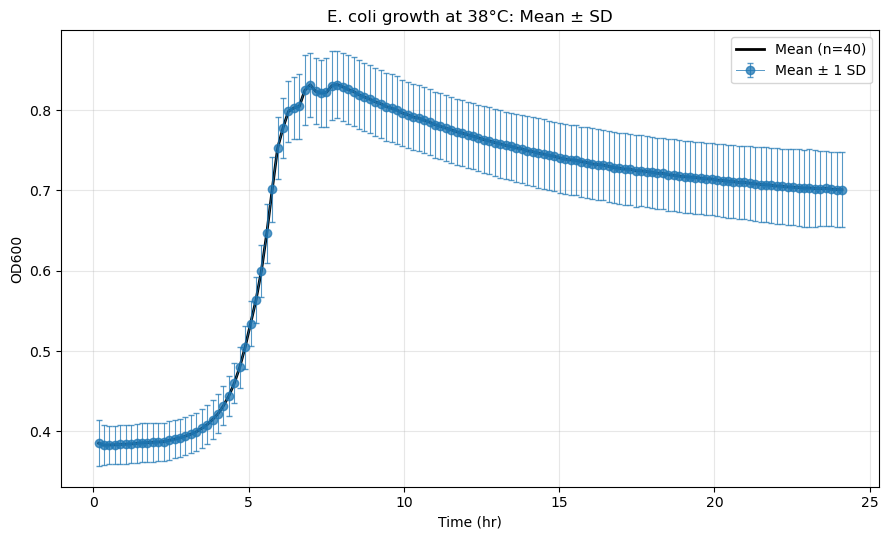

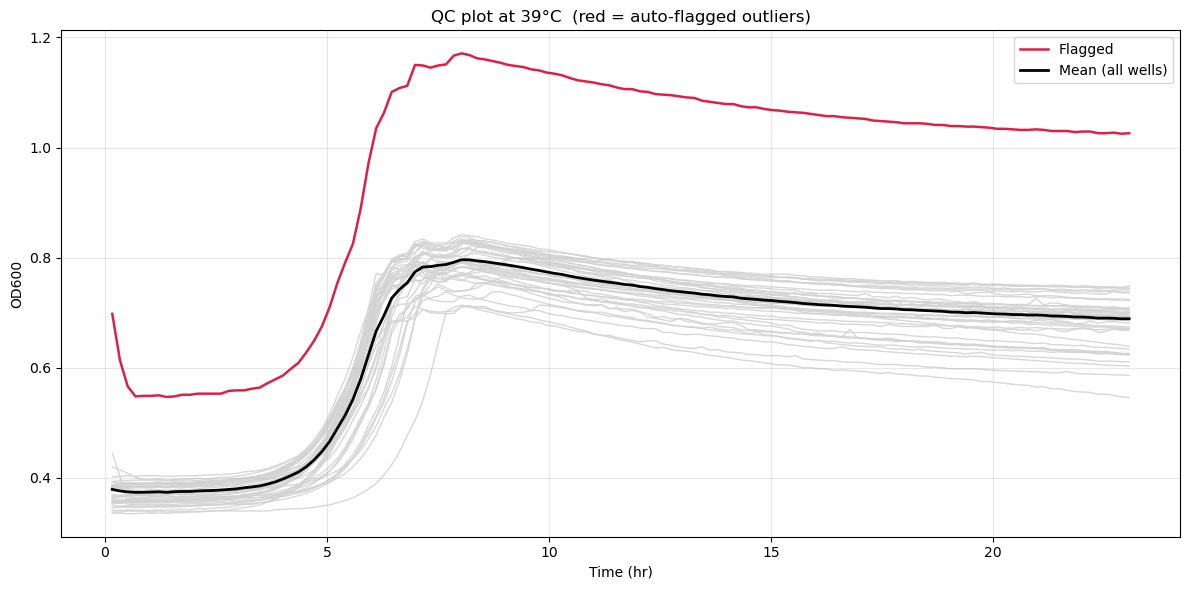

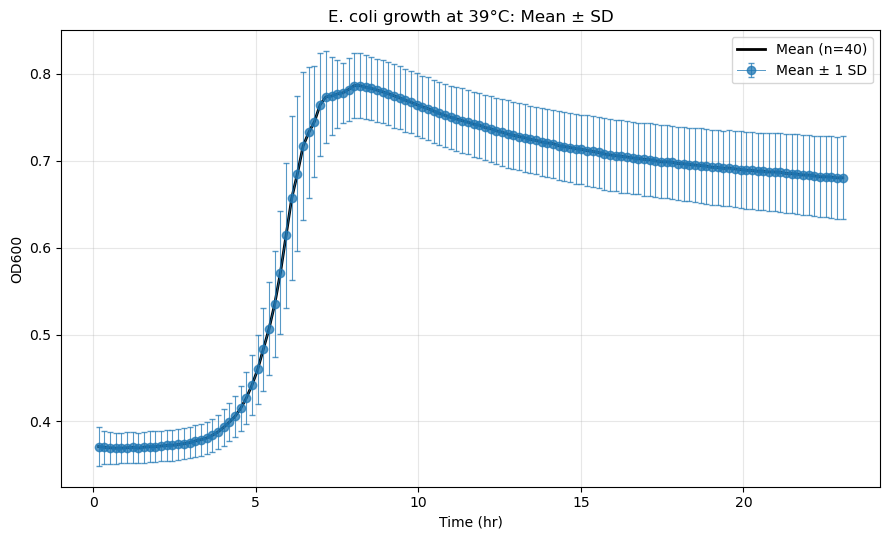

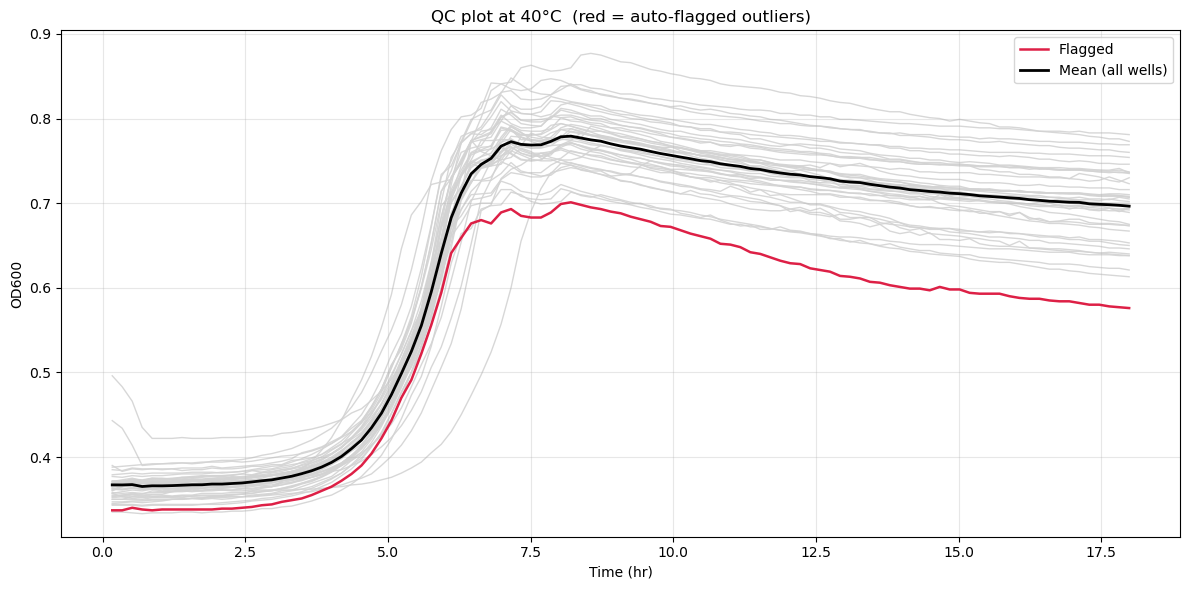

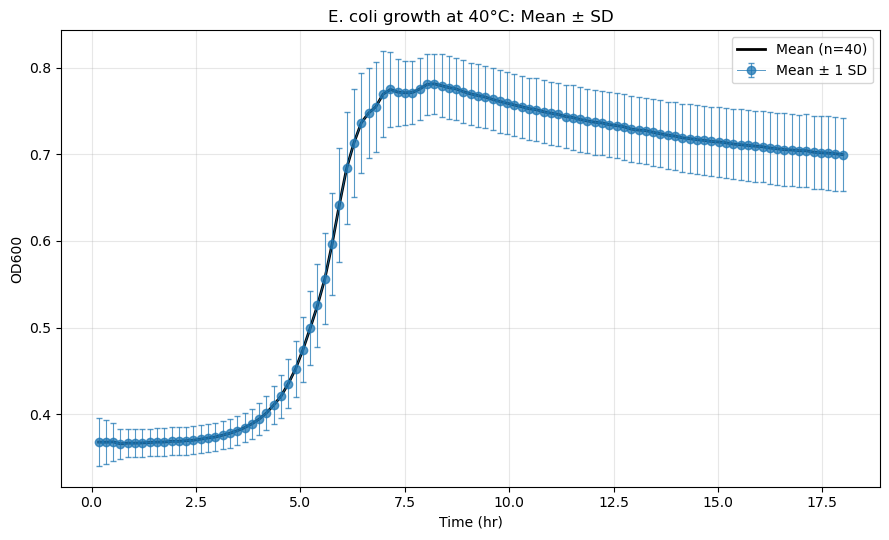

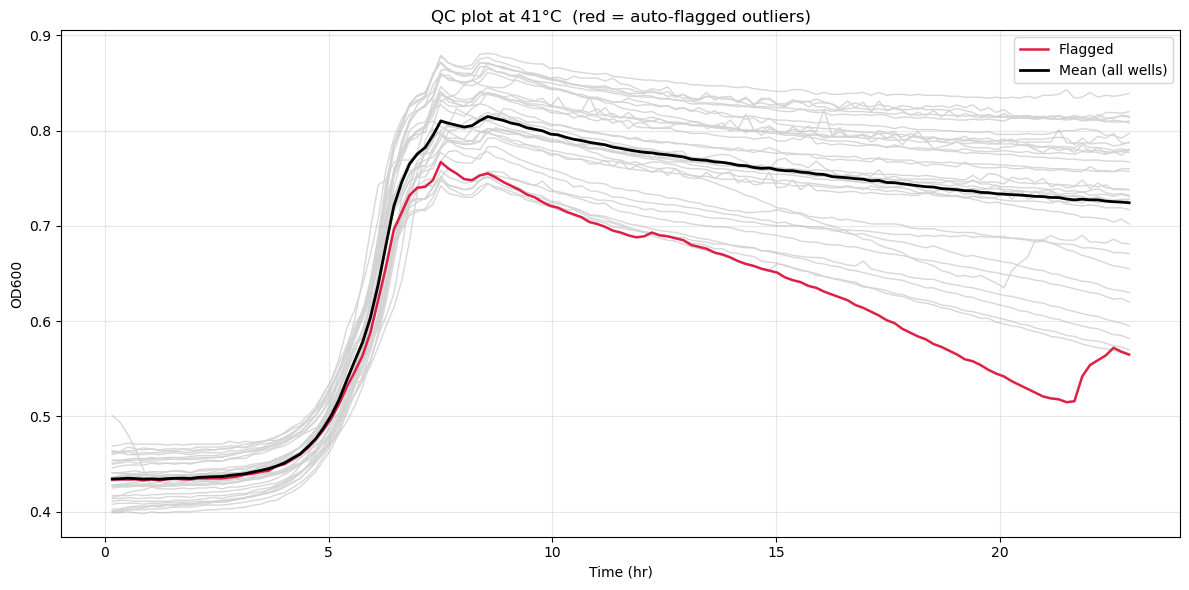

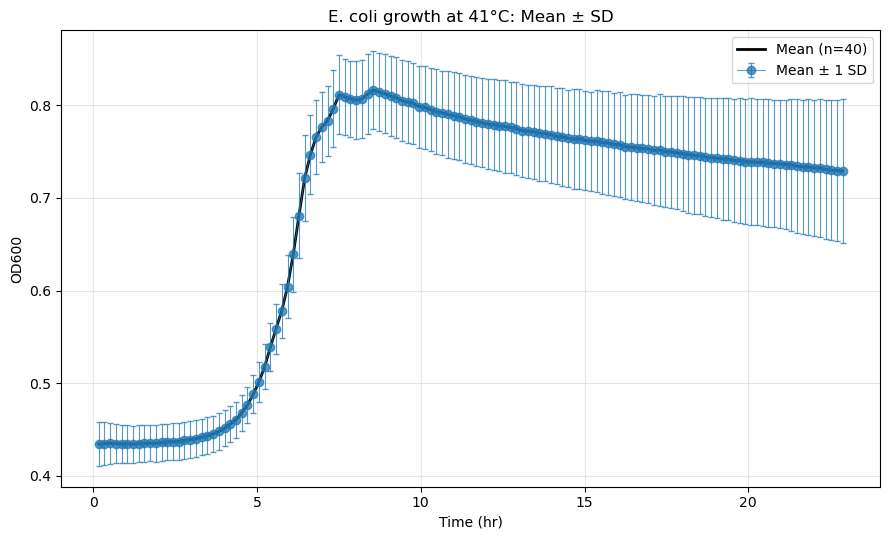

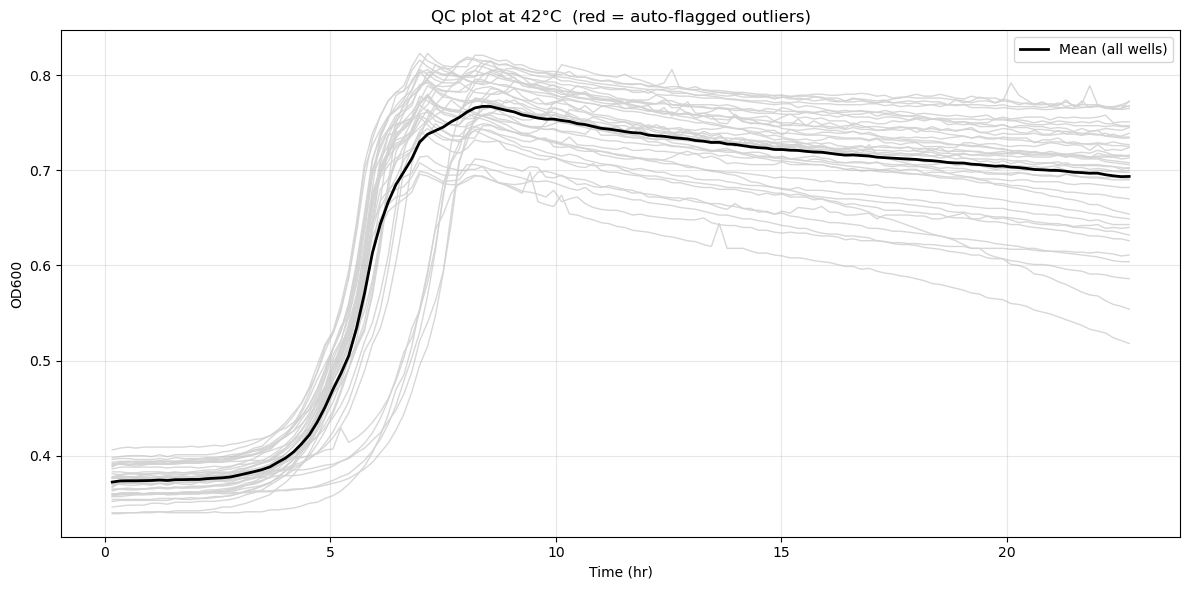

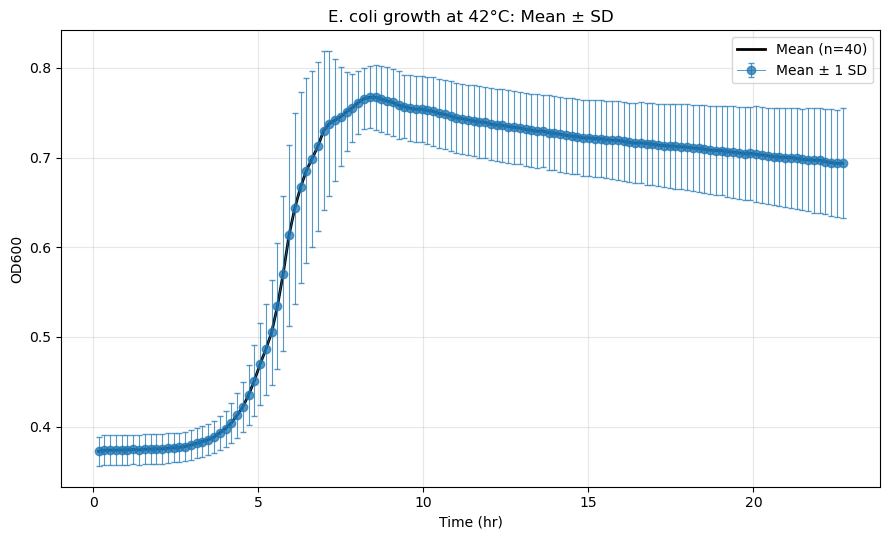

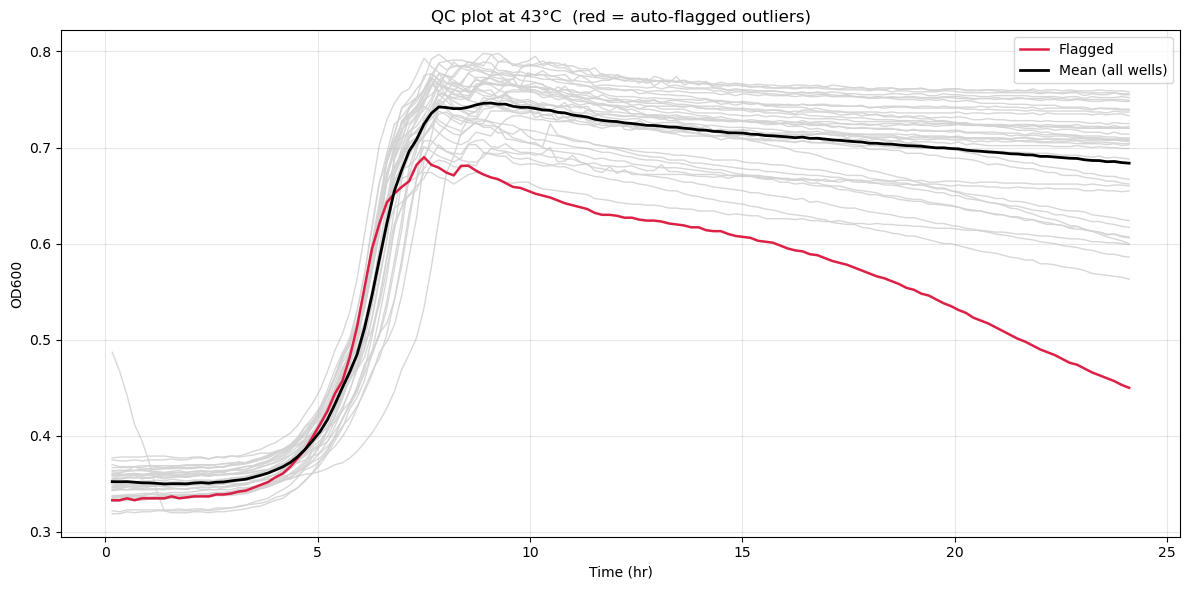

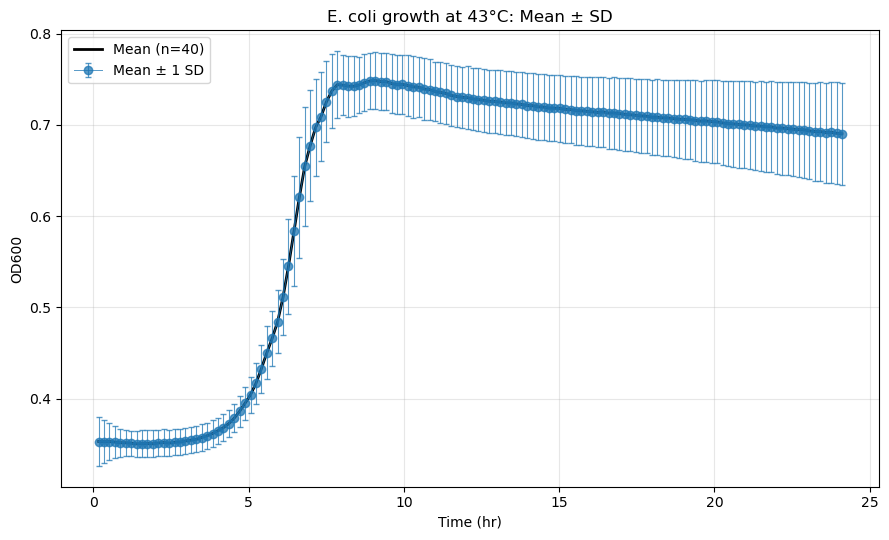

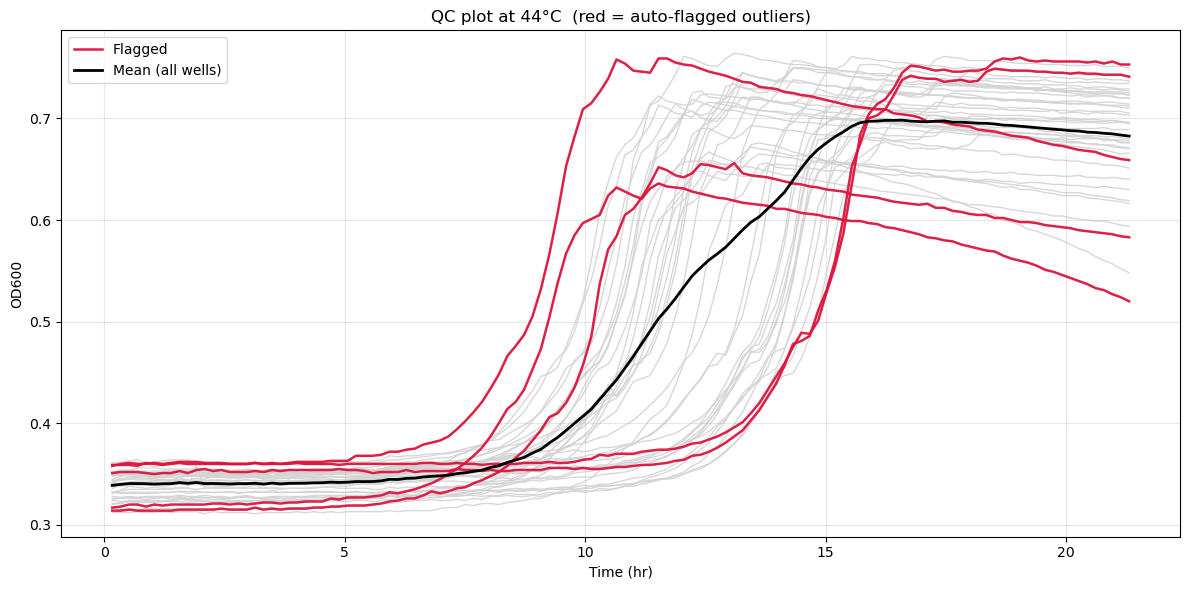

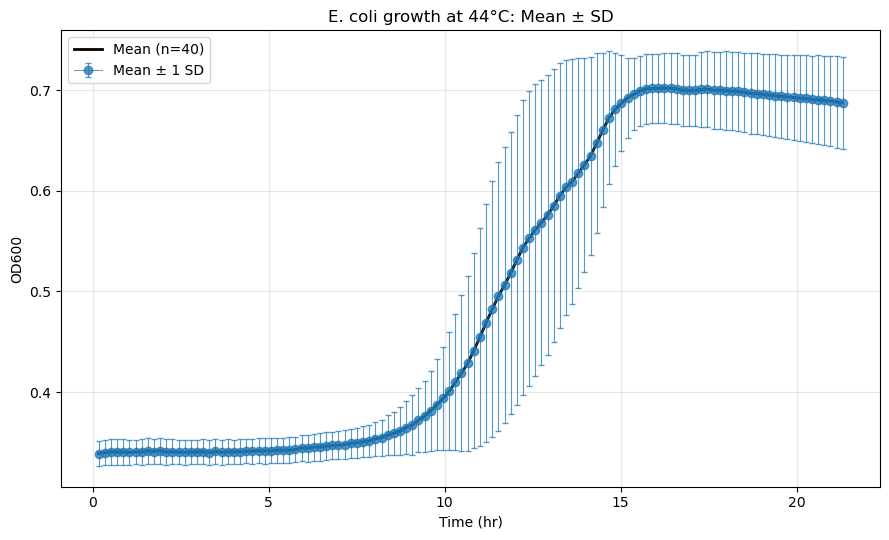

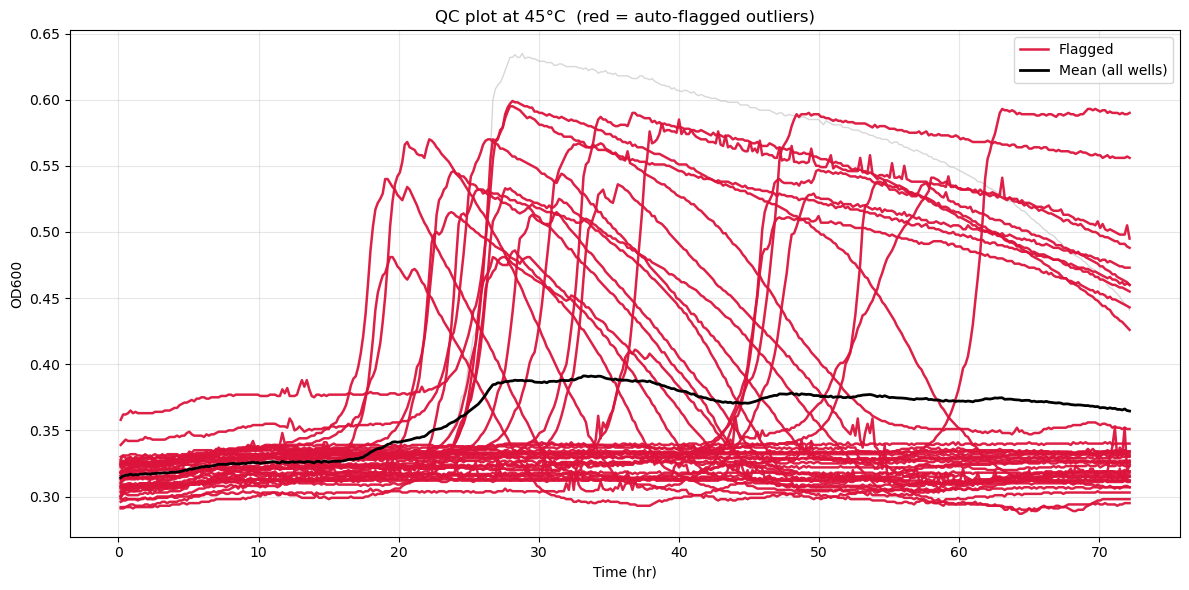

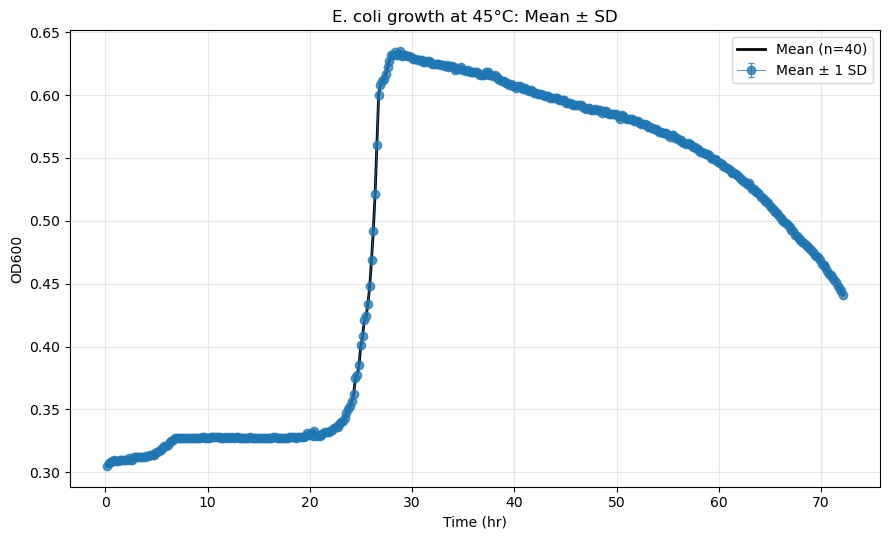

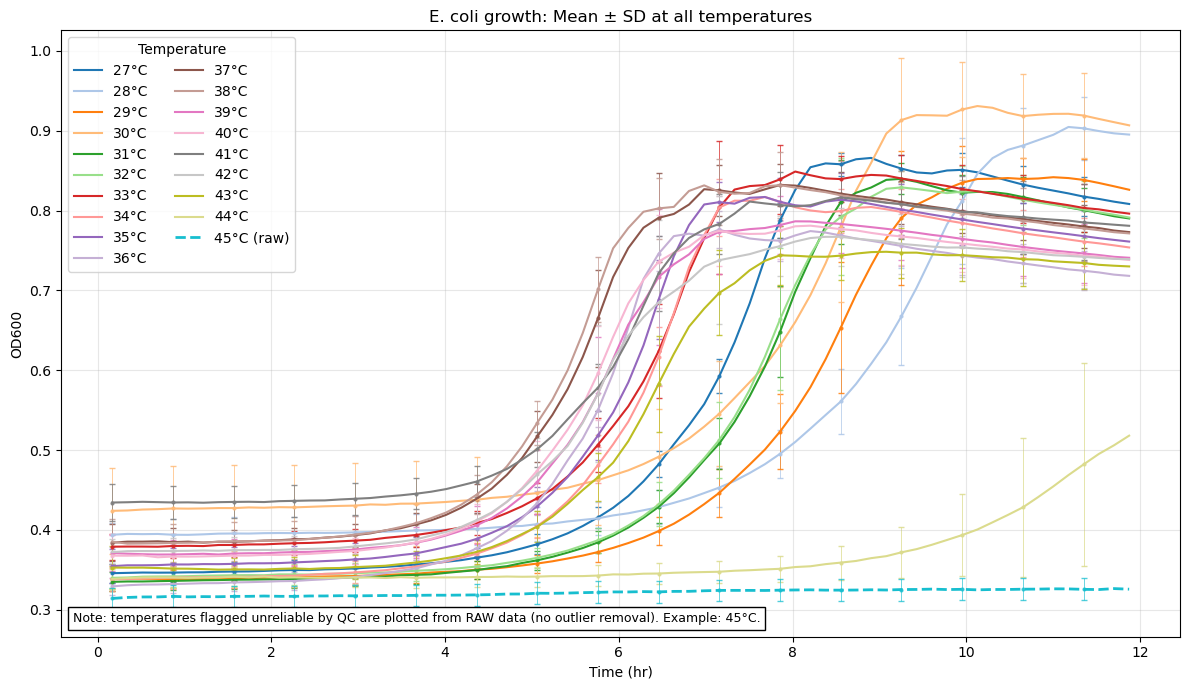

Replaced single-temperature figures for unreliable temps with RAW versions.


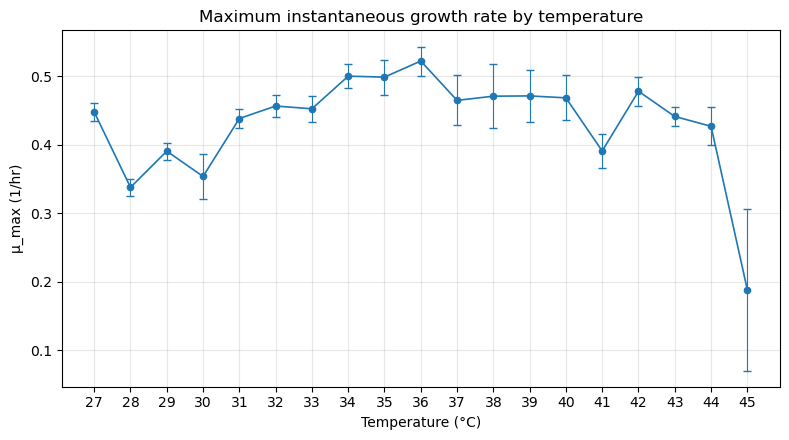


=== 正态性检验（Shapiro-Wilk） + 可视化（Histogram/KDE + QQ）===

[36°C] Shapiro-Wilk: W=0.985, p=0.8651, n=39
[37°C] Shapiro-Wilk: W=0.973, p=0.4816, n=38

Shapiro 总结：
  temp_C  shapiro_W  p_value  n
     36   0.984743 0.865087 39
     37   0.973098 0.481550 38

=== 方差齐性检验（Levene）===

Levene (36 vs 37): stat=8.199, p=0.0054  ->  Unequal variances(<0.05)

=== Welch’s t-test (36°C vs 37°C) ===
36°C: n=39, mean=0.5221, sd=0.0212
37°C: n=38, mean=0.4648, sd=0.0366
t=8.400, df≈59.0, p=0.0000
Mean difference (36-37) = 0.0574  [95% CI: 0.0437, 0.0710]
Hedges' g = 1.908  (|g|≈0.2小, 0.5中, 0.8大)

结论 (Chinese): 在方差不齐前提下使用 Welch’s t-test，p < 0.05，说明 **36°C 与 37°C 的平均最大生长速率存在显著差异**。结合差值与置信区间，36°C 相比 37°C 的均值差为 0.0574（95%CI: 0.0437 ~ 0.0710）。

Conclusion (English): Under the assumption of unequal variances, Welch’s t-test was applied. Since p < 0.05, there is a **significant difference in the mean maximum growth rate between 36°C and 37°C**. The mean difference (36°C – 37°C) is 0.0574, with 95% CI: 0.0437 ~ 0

In [19]:
# ======= Standard header / 标准头部元信息（每个脚本可统一复用） =======
__author__   = "Chengxi Xu"
__affil__    = "Molecular Biotech"
__email__    = "ch1662xu-s@student.lu.se"
__status__   = "BioChemistry/projects/notebook3"
__copyright__= "2025, Lund University"
__license__  = "For course use only"
__version__  = "0.1.2"
__date__     = "2025-09-08/09-14"

#打开文件夹路径为D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\ecoli_growth_data

# ======= Imports / 导入常用库（通用前期设定，可直接借鉴） =======
import os                # File & path utilities / 文件与路径工具
import re
import glob
import sys               # System utilities / 系统工具
from sys import exit     # Quick exit / 便捷退出
import argparse          # CLI arguments / 命令行参数
import numpy as np       # Numerics / 数值计算
import pandas as pd      # DataFrames / 表格数据处理
import matplotlib.pyplot as plt                          
from matplotlib.offsetbox import AnchoredText            
from scipy.stats import spearmanr
from scipy.stats import anderson  
from scipy.stats import t                      
from scipy import stats
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from tabulate import tabulate
from matplotlib import cm, colors as mcolors
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
from scipy.interpolate import make_interp_spline

# 指定数据所在目录（原始 csv）、处理后结果目录、图像保存目录
# 原始数据目录（19个xls文件）
data_dir = r"D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\ecoli_growth_data"
# 处理后的数据保存位置
processed_dir = r"D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\processed_data"
# 图像保存位置
fig_dir = r"D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\fig_mean_std"
qc_dir      = r"D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\qc_reports"
cleaned_dir = r"D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\cleaned_data"

# 如果目录不存在就创建，避免后续保存时报错
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(qc_dir, exist_ok=True)
os.makedirs(cleaned_dir, exist_ok=True)

# 1) 从文件名中解析温度（例如 "Ecoli_MicroplateGrowth_37C_Filtered.csv" → 37）
def parse_temp(fname):
    m = re.search(r'_(\d{2})C_', fname)   # 匹配文件名里形如 "_37C_" 的部分
    return int(m.group(1)) if m else None # 如果匹配成功就取出温度数字，否则返回 None

# 2) 给 DataFrame 添加统计量（Mean / Std / Median）
def add_stats(df):
    cols = [c for c in df.columns if c != "Time_in_hr"]  # 除去时间列，留下 40 个孔的数据
    out = df.copy()                                      # 复制一份，避免修改原数据
    out["Mean"]   = out[cols].mean(axis=1)               # 每个时间点的 40 孔均值
    out["Std"]    = out[cols].std(axis=1)                # 每个时间点的 40 孔标准差
    out["Median"] = out[cols].median(axis=1)             # 每个时间点的 40 孔中位数
    return out

# 3) 绘制 “均值 ± 标准差” 图，并保存成 PNG
def plot_mean_std(df_stats, temp, out_png):
    fig, ax = plt.subplots(figsize=(9,5.5))

    # 黑色粗线：40 个重复的均值
    ax.plot(df_stats["Time_in_hr"], df_stats["Mean"],
            color="black", lw=2.0, label="Mean (n=40)")

    # 蓝色点+线：均值曲线，并附带标准差误差棒
    ax.errorbar(df_stats["Time_in_hr"], df_stats["Mean"], yerr=df_stats["Std"],
                fmt="o-", color="tab:blue", lw=0.7, elinewidth=0.8,
                capsize=2, alpha=0.75, label="Mean ± 1 SD")

    # 设置坐标轴与标题
    ax.set(xlabel="Time (hr)", ylabel="OD600",
           title=f"E. coli growth at {temp}°C: Mean ± SD")

    # 网格 & 图例
    ax.grid(True, alpha=0.3)
    ax.legend()

    # 自动布局 & 保存到文件
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
#    plt.close(fig)  # 关闭图像，避免 Notebook 循环时内存爆掉

# === QC 指标 ===
def compute_qc_metrics(df: pd.DataFrame) -> pd.DataFrame:
    wells = [c for c in df.columns if c != "Time_in_hr"]
    time = df["Time_in_hr"].to_numpy()
    mean_curve = df[wells].mean(axis=1).to_numpy()

    rows = []
    for w in wells:
        y = df[w].to_numpy()
        dyn_range = np.nanmax(y) - np.nanmin(y)
        rmse = np.sqrt(np.nanmean((y - mean_curve) ** 2))
        try:
            r, _ = pearsonr(y, mean_curve)
        except Exception:
            r = np.nan
        t_at_max = time[np.nanargmax(y)]
        auc = np.trapz(y, time)
        rows.append({"well": w, "dyn_range": dyn_range,
                     "rmse_to_mean": rmse, "pearson_r": r,
                     "t_at_max": t_at_max, "auc": auc})
    return pd.DataFrame(rows)

# === 标记 outlier（阈值可调） ===
def flag_outliers(metrics: pd.DataFrame,
                  dyn_min=0.15, r_min=0.90, rmse_factor=3.0) -> pd.DataFrame:
    m = metrics.copy()
    rmse_med = m["rmse_to_mean"].median()
    m["flag_dyn"]  = m["dyn_range"]   < dyn_min
    m["flag_r"]    = m["pearson_r"]   < r_min
    m["flag_rmse"] = m["rmse_to_mean"] > (rmse_med * rmse_factor)
    m["is_outlier"] = m[["flag_dyn","flag_r","flag_rmse"]].any(axis=1)
    return m

# === QC 图（保存到 qc_dir；默认不 show；关闭 fig） ===
def plot_qc(df: pd.DataFrame, flagged: pd.DataFrame, temp: int, out_png: str, show: bool=False):
    wells = [c for c in df.columns if c != "Time_in_hr"]
    time = df["Time_in_hr"].to_numpy()
    flags = dict(zip(flagged["well"], flagged["is_outlier"]))

    fig, ax = plt.subplots(figsize=(12, 6))
    # 灰色：保留
    for w in wells:
        if not flags.get(w, False):
            ax.plot(time, df[w], color="lightgray", lw=1.0, alpha=0.9, zorder=1)
    # 红色：异常
    first_flag = True
    for w in wells:
        if flags.get(w, False):
            ax.plot(time, df[w], color="crimson", lw=1.8, alpha=0.95, zorder=2,
                    label="Flagged" if first_flag else None)
            first_flag = False

    mean_curve = df[wells].mean(axis=1).to_numpy()
    ax.plot(time, mean_curve, color="black", lw=2.0, label="Mean (all wells)")

    ax.set_xlabel("Time (hr)"); ax.set_ylabel("OD600")
    ax.set_title(f"QC plot at {temp}°C  (red = auto-flagged outliers)")
    ax.grid(True, alpha=0.3); ax.legend()
    fig.tight_layout(); fig.savefig(out_png, dpi=220)
    if show:
        plt.show()
#    plt.close(fig)  # 关键：关闭图像

# 处理所有温度，收集每个温度的 Mean 曲线用于总览图
mean_curves = {}  # {temp: (time, mean)}

qc_rows = []              # 用来收集每个温度的QC摘要
min_n_kept = 3            # 可信度阈值：保留孔数 < 3 则标记为不可靠（可改）
# 记录这次 QC 判定所用的阈值，方便写入摘要表 （与这里做同步 === 标记 outlier（阈值可调） ===
qc_params = {"dyn_min": 0.15, "r_min": 0.90, "rmse_factor": 3.0}

for path in glob.glob(os.path.join(data_dir, "*.csv")):
    fname = os.path.basename(path)
    temp = parse_temp(fname)
    if temp is None:
        continue

    df = pd.read_csv(path)
    df_stats = add_stats(df)
    

    # 1) QC 指标 & 标记
    metrics = compute_qc_metrics(df)
    flagged = flag_outliers(metrics)

    # 2) 生成 QC 图 —— 保存到 qc_dir
    qc_png = os.path.join(qc_dir, f"QC_{temp}C.png")
    plot_qc(df, flagged, temp, qc_png, show=False)

    # 3) 清洗：只保留非 outlier 的孔
    keep_wells = flagged.loc[~flagged["is_outlier"], "well"].tolist()
    cleaned_df = pd.concat([df[["Time_in_hr"]], df[keep_wells]], axis=1)

    # === 追加该温度的 QC 摘要信息 ===
    # 总孔数（不含时间列）
    n_total   = df.shape[1] - 1
    n_flagged = int(flagged["is_outlier"].sum())
    n_kept    = n_total - n_flagged
    pct_kept  = round(100.0 * n_kept / n_total, 2) if n_total > 0 else 0.0

    qc_rows.append({
        "temp_C": temp,
        "n_total": n_total,
        "n_flagged": n_flagged,
        "n_kept": n_kept,
        "pct_kept": pct_kept,
    # 记录本次 QC 的参数 & 一些中位统计，便于以后复核
        "rmse_median": round(flagged["rmse_to_mean"].median(), 6),
        "dyn_min_used": qc_params["dyn_min"],
        "r_min_used": qc_params["r_min"],
        "rmse_factor_used": qc_params["rmse_factor"],
        "note": ""  # 先留空，汇总表里再根据 n_kept 写提醒
    })

    # 4) 保存清洗后的原始孔数据（供以后复查/复用）
    cleaned_csv = os.path.join(cleaned_dir, f"Cleaned_{temp}C.csv")
    cleaned_df.to_csv(cleaned_csv, index=False)

    # 5) 计算统计量 & 保存到 processed（下游作图直接用）
    df_stats = add_stats(cleaned_df)
    out_csv = os.path.join(processed_dir, f"Processed_{temp}C.csv")
    df_stats.to_csv(out_csv, index=False)

    # 6) 单温度 Mean±SD 图 —— 保存到 fig_dir
    out_png = os.path.join(fig_dir, f"MeanStd_{temp}C.png")
    plot_mean_std(df_stats, temp, out_png)

    # 7) 收集 24h 内的 mean，用于“全部温度总览图”
    df_stats_24 = df_stats[df_stats["Time_in_hr"] <= 24]
    mean_curves[temp] = (df_stats_24["Time_in_hr"].values, df_stats_24["Mean"].values)

# ===== 汇总并导出 QC 摘要 =====
qc_df = pd.DataFrame(qc_rows).sort_values("temp_C")

# 可信度提示：保留孔数太少时打红旗
qc_df["reliability_flag"] = np.where(
    qc_df["n_kept"] < min_n_kept,
    f"UNRELIABLE: n_kept<{min_n_kept}",
    ""
)

# 保存到 CSV（下次运行时就能复用）
qc_summary_path = os.path.join(qc_dir, "QC_summary_by_temperature.csv")
qc_df.to_csv(qc_summary_path, index=False)

# 与我们在汇总时用的一致：n_kept < min_n_kept 就视为不可靠
qc_df["is_reliable"] = qc_df["n_kept"] >= min_n_kept

reliable_temps   = sorted(qc_df.loc[qc_df["is_reliable"], "temp_C"].astype(int).tolist())
unreliable_temps = sorted(qc_df.loc[~qc_df["is_reliable"], "temp_C"].astype(int).tolist())

print("Reliable temps   :", reliable_temps)
print("Unreliable temps :", unreliable_temps)

# —— 主图：把可靠温度（clean）+ 不可靠温度（raw）一起画出来
# 1) 可靠温度：读 processed（clean 后）
reliable_dict = {}
for t in reliable_temps:
    fp = os.path.join(processed_dir, f"Processed_{t}C.csv")
    if not os.path.exists(fp):
        continue
    df = pd.read_csv(fp)
    df = df[df["Time_in_hr"] <= 12].reset_index(drop=True)   # 你想要的时窗
    reliable_dict[t] = df

# 2) 不可靠温度：读 RAW（不做 outlier 去除）
raw_dict = {}
for t in unreliable_temps:
    raw_fp = os.path.join(data_dir, f"Ecoli_MicroplateGrowth_{t}C_Filtered.csv")
    if not os.path.exists(raw_fp):
        continue
    raw_df = pd.read_csv(raw_fp)
    raw_stats = add_stats(raw_df)                            # 直接统计 Mean/Std
    raw_stats = raw_stats[raw_stats["Time_in_hr"] <= 12].reset_index(drop=True)
    raw_dict[t] = raw_stats

# 3) 画图：可靠(实线) + 不可靠(虚线 RAW)
all_temps = sorted(reliable_dict.keys()) + sorted(raw_dict.keys())
cmap      = plt.get_cmap("tab20")
colors    = [cmap(i % 20) for i in range(len(all_temps))]

plt.figure(figsize=(12, 7))
step = 4   # 误差棒降采样；如果想每个点都有误差棒，改成 1

for c, t in zip(colors, all_temps):
    if t in reliable_dict:                        # —— 可靠温度（clean）
        df = reliable_dict[t]
        # 曲线
        plt.plot(df["Time_in_hr"], df["Mean"],
                 color=c, lw=1.5, label=f"{t}°C", zorder=2)
        # 误差棒（降采样）
        sel = df.iloc[::step, :]
        plt.errorbar(sel["Time_in_hr"], sel["Mean"], yerr=sel["Std"],
                     fmt="o", ms=2.0, lw=0.6, elinewidth=0.6, capsize=2,
                     color=c, alpha=0.85, zorder=1)
    else:                                         # —— 不可靠温度（RAW）
        df = raw_dict[t]
        # 虚线 + (raw) 标签
        plt.plot(df["Time_in_hr"], df["Mean"],
                 color=c, lw=2.0, ls="--", label=f"{t}°C (raw)", zorder=3)
        sel = df.iloc[::step, :]
        plt.errorbar(sel["Time_in_hr"], sel["Mean"], yerr=sel["Std"],
                     fmt="o", ms=2.0, lw=0.6, elinewidth=0.6, capsize=2,
                     color=c, alpha=0.75, zorder=2)

plt.xlabel("Time (hr)")
plt.ylabel("OD600")
plt.title("E. coli growth: Mean ± SD at all temperatures")
plt.grid(True, alpha=0.3)
plt.legend(title="Temperature", ncol=2, frameon=True)

# 左下角加说明：哪些温度是 RAW
# from matplotlib.offsetbox import AnchoredText
if len(raw_dict) > 0:
    note = ("Note: temperatures flagged unreliable by QC are plotted from RAW data "
            "(no outlier removal). Example: " +
            ", ".join(f"{t}°C" for t in sorted(raw_dict.keys())) + ".")
    at = AnchoredText(note, prop=dict(size=9), loc="lower left", frameon=True)
    plt.gca().add_artist(at)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "AllTemps_Mean_SD_Errorbars.png"), dpi=240)
plt.show()


# ===== 覆盖不可靠温度的单温度图：用 RAW 重画并覆盖 MeanStd_{t}C.png =====
##### 这里应该可以优化？
# 读 QC 摘要，找出不可靠温度（比如 45°C）
qc_summary_path = os.path.join(qc_dir, "QC_summary_by_temperature.csv")
qc_df = pd.read_csv(qc_summary_path)
min_n_kept = 3                           # 阈值
unreliable_temps = set(qc_df.loc[qc_df["n_kept"] < min_n_kept, "temp_C"].astype(int))

for t in sorted(unreliable_temps):
    # 找原始 csv（不做清洗）
    raw_fp = os.path.join(data_dir, f"Ecoli_MicroplateGrowth_{t}C_Filtered.csv")
    if not os.path.exists(raw_fp):
        print(f"[WARN] raw csv not found for {t}C:", raw_fp)
        continue

    raw_df = pd.read_csv(raw_fp)
    raw_stats = add_stats(raw_df)


    raw_stats = raw_stats.reset_index(drop=True)  #保持原来“单温度图”时窗

    # 从 QC 表里取 n_kept/n_total 用于标题
    row = qc_df.loc[qc_df["temp_C"] == t].iloc[0]
    n_kept, n_total = int(row["n_kept"]), int(row["n_total"])

    # 画 RAW 的 Mean±SD，并用“同名文件”覆盖（如 MeanStd_45C.png）
    out_png = os.path.join(fig_dir, f"MeanStd_{t}C.png")   # 覆盖之前的那张
    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.plot(raw_stats["Time_in_hr"], raw_stats["Mean"],
            color="black", lw=2.0, label="Mean (RAW)")
    # 需要每个点都画误差棒的话，把 step=1 或直接用 raw_stats 替换 sel
    step = 4
    sel = raw_stats.iloc[::step, :]
    ax.errorbar(sel["Time_in_hr"], sel["Mean"], yerr=sel["Std"],
                fmt="o", ms=2.0, lw=0.6, elinewidth=0.6, capsize=2,
                color="tab:red", alpha=0.9, label="Mean ± 1 SD (RAW)")

    ax.set_xlabel("Time (hr)")
    ax.set_ylabel("OD600")
    ax.set_title(f"{t}°C — RAW shown (QC kept {n_kept}/{n_total}, unreliable)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    fig.savefig(out_png, dpi=220)  # ← 与原图同名，直接覆盖
    plt.close(fig)

print("Replaced single-temperature figures for unreliable temps with RAW versions.")


# 求最大生长速率
# 新建 growth_rates 文件夹
growth_rate_dir = r"D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\growth_rates"
os.makedirs(growth_rate_dir, exist_ok=True)

def load_df_for_temp(temp:int) -> tuple[pd.DataFrame, str]:
#返回 (df, source)：- 除 45°C 外，优先读 processed（清洗后），不存在则回退 raw   - 45°C 强制用 raw
    proc_fp = os.path.join(processed_dir, f"Processed_{temp}C.csv")
    raw_fp  = os.path.join(data_dir,      f"Ecoli_MicroplateGrowth_{temp}C_Filtered.csv")
    if temp == 45:
        src = "RAW"
        df  = pd.read_csv(raw_fp)
    else:
        if os.path.exists(proc_fp):
            src = "PROCESSED"
            df  = pd.read_csv(proc_fp)
        else:
            src = "RAW"
            df  = pd.read_csv(raw_fp)
    return df, src

def infer_well_cols(df: pd.DataFrame):
#找出孔列名（排除统计列）；若没有孔列，则尝试仅用 Mean 列。
    well_cols = [c for c in df.columns if c not in ("Time_in_hr","Mean","Std","Median")]
    if len(well_cols)==0 and "Mean" in df.columns:
        well_cols = ["Mean"]
    return well_cols

def compute_mu_series(time: np.ndarray, od: np.ndarray, eps: float=1e-6) -> np.ndarray:
    #用所有点计算瞬时增长率：mu(t) = d ln(OD)/dt - time: 形如 (N,) - od:   形如 (N,) 返回 mu(t) 数组（形如 (N,)）
    od = np.asarray(od, dtype=float)
    time = np.asarray(time, dtype=float)
    # 防止 log(0)
    ln_od = np.log(np.clip(od, a_min=eps, a_max=None))
    # 用 numpy.gradient 对不等距时间也稳健
    mu = np.gradient(ln_od, time)
    return mu

# =============== 主循环：27–45 °C ===============
rows_by_well = []     # 逐孔 mu_max 汇总
rows_by_temp = []     # 逐温度聚合汇总

for temp in range(27, 46):
    # 跳过不存在的温度文件
    raw_fp  = os.path.join(data_dir, f"Ecoli_MicroplateGrowth_{temp}C_Filtered.csv")
    proc_fp = os.path.join(processed_dir, f"Processed_{temp}C.csv")
    if (temp != 45) and (not os.path.exists(proc_fp)) and (not os.path.exists(raw_fp)):
        continue

    df, source = load_df_for_temp(temp)

    # 时间轴 & 列
    time = df["Time_in_hr"].to_numpy()
    well_cols = infer_well_cols(df)

    # 逐孔计算 mu(t)，并记录 mu_max
    mu_df = pd.DataFrame({"Time_in_hr": time})
    mu_max_list = []

    for w in well_cols:
        mu = compute_mu_series(time, df[w].to_numpy())
        mu_df[w] = mu

        # mu_max & 出现时间
        if np.all(~np.isfinite(mu)):
            mu_max = np.nan
            t_at_mu_max = np.nan
        else:
            idx = np.nanargmax(mu)   # 忽略 NaN 后的最大索引
            mu_max = mu[idx]
            t_at_mu_max = time[idx]

        mu_max_list.append(mu_max)
        rows_by_well.append({
            "temp_C": temp,
            "source": source,      # RAW / PROCESSED
            "well": w,
            "n_points": int(len(time)),
            "mu_max": float(mu_max),
            "t_at_mu_max_hr": float(t_at_mu_max)
        })

    # 保存每个温度的 mu(t) 全序列（可用于复查）
    mu_out = os.path.join(processed_dir, f"MU_Timeseries_{temp}C.csv")
    mu_df.to_csv(mu_out, index=False)

    # 逐温度聚合
    mu_max_arr = np.array(mu_max_list, dtype=float)
    mu_max_arr = mu_max_arr[np.isfinite(mu_max_arr)]
    n_wells = len(mu_max_arr)
    rows_by_temp.append({
        "temp_C": temp,
        "source": source,
        "n_wells": int(n_wells),
        "mu_max_mean": float(np.nanmean(mu_max_arr)) if n_wells>0 else np.nan,
        "mu_max_std":  float(np.nanstd(mu_max_arr, ddof=1)) if n_wells>1 else np.nan,
        "mu_max_median": float(np.nanmedian(mu_max_arr)) if n_wells>0 else np.nan,
        "mu_max_min": float(np.nanmin(mu_max_arr)) if n_wells>0 else np.nan,
        "mu_max_max": float(np.nanmax(mu_max_arr)) if n_wells>0 else np.nan,
    })

# ====== 汇总表写盘 ======
mu_by_well_df  = pd.DataFrame(rows_by_well).sort_values(["temp_C","well"])
mu_by_temp_df  = pd.DataFrame(rows_by_temp).sort_values("temp_C")
mu_by_well_csv = os.path.join(processed_dir, "mu_max_by_well.csv")
mu_by_temp_csv = os.path.join(processed_dir, "mu_max_summary_by_temperature.csv")
mu_by_well_df.to_csv(mu_by_well_csv, index=False)
mu_by_temp_df.to_csv(mu_by_temp_csv, index=False)

# ====== 温度-均值增长率的总览图 ======
fig, ax = plt.subplots(figsize=(8,4.5))
ax.errorbar(mu_by_temp_df["temp_C"], mu_by_temp_df["mu_max_mean"],
            yerr=mu_by_temp_df["mu_max_std"],
            fmt="o-", capsize=3,
            color="tab:blue", markersize=4.5,  # 调小点
            elinewidth=0.8, lw=1.2)            # 误差棒和线更细
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("μ_max (1/hr)")
ax.set_title("Maximum instantaneous growth rate by temperature")
ax.grid(True, alpha=0.3)
# 设置横坐标只显示整数温度
ax.set_xticks(range(27, 46))   # 27–45°C 的范围
fig.tight_layout()
fig.savefig(os.path.join(growth_rate_dir, "μ_Max_vs_Temperature.png"), dpi=220)
plt.show()

####================== 验证36 vs 37 的统计学检验 ========================

# ===== 路径（保持与你工程一致）=====
processed_dir    = r"D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\processed_data"
growth_rate_dir  = r"D:\JupyterProjects\BioChemistry\BioChemistry\projects\notebook3\growth_rates"
stats_report_dir = os.path.join(growth_rate_dir, "stats_checks_36_37")
os.makedirs(stats_report_dir, exist_ok=True)

# 你之前导出的逐孔 μ_max 表（已经在你的流程里写盘）
mu_by_well_csv = os.path.join(processed_dir, "mu_max_by_well.csv")

# 读取并只保留 36 和 37°C
df_mu = pd.read_csv(mu_by_well_csv)
df_mu = df_mu[df_mu["temp_C"].isin([36, 37])].copy()
df_mu = df_mu[np.isfinite(df_mu["mu_max"])]

# ========== 正态性检验（Shapiro-Wilk） + 可视化 ==========
print("\n=== 正态性检验（Shapiro-Wilk） + 可视化（Histogram/KDE + QQ）===\n")
results_normality = []

for temp, g in df_mu.groupby("temp_C"):
    x = g["mu_max"].values
    W, p = stats.shapiro(x)
    results_normality.append({"temp_C": int(temp), "shapiro_W": W, "p_value": p, "n": len(x)})

    print(f"[{int(temp)}°C] Shapiro-Wilk: W={W:.3f}, p={p:.4f}, n={len(x)}")

    # 分布直方图
    plt.figure(figsize=(5,3.2))
    sns.histplot(x, kde=True, color="tab:blue", bins=8)
    plt.title(f"{int(temp)}°C  μ_max distribution")
    plt.xlabel("μ_max (1/hr)"); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(stats_report_dir, f"{int(temp)}C_mu_max_hist.png"), dpi=220)
    plt.close()

    # QQ 图
    fig = sm.qqplot(x, line='s')
    plt.title(f"QQ plot — {int(temp)}°C μ_max")
    plt.tight_layout()
    plt.savefig(os.path.join(stats_report_dir, f"{int(temp)}C_mu_max_QQ.png"), dpi=220)
    plt.close()

normality_df = pd.DataFrame(results_normality).sort_values("temp_C")
print("\nShapiro 总结：\n", normality_df.to_string(index=False))

normality_df.to_csv(os.path.join(stats_report_dir, "normality_shapiro_summary.csv"), index=False)

# ========== 方差齐性检验（Levene） ==========
print("\n=== 方差齐性检验（Levene）===\n")
x36 = df_mu[df_mu["temp_C"]==36]["mu_max"].values
x37 = df_mu[df_mu["temp_C"]==37]["mu_max"].values

stat, p = stats.levene(x36, x37, center='median')  # 两组比较
print(f"Levene (36 vs 37): stat={stat:.3f}, p={p:.4f}  ->  {'Homogeneity of variances holds(>0.05)' if p>0.05 else 'Unequal variances(<0.05)'}")

#### ============ Welch’s t-test: 36°C vs 37°C（方差不齐时使用）================
# 取两组数据
x36 = df_mu.loc[df_mu["temp_C"] == 36, "mu_max"].dropna().to_numpy()
x37 = df_mu.loc[df_mu["temp_C"] == 37, "mu_max"].dropna().to_numpy()

n1, n2 = len(x36), len(x37)
m1, m2 = np.mean(x36), np.mean(x37)
s1, s2 = np.std(x36, ddof=1), np.std(x37, ddof=1)

# Welch t-test
t_stat, p_val = stats.ttest_ind(x36, x37, equal_var=False)

# Welch–Satterthwaite 自由度
se_diff = np.sqrt(s1**2/n1 + s2**2/n2)
df_welch = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
t_crit = stats.t.ppf(0.975, df_welch)  # 95% CI
diff = m1 - m2
ci_low, ci_high = diff - t_crit*se_diff, diff + t_crit*se_diff

# 效应量：Hedges' g（对 Cohen's d 做小样本修正）
sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
d = (m1 - m2) / sp
J = 1 - 3/(4*(n1+n2)-9)   # 小样本修正因子
g = J * d

# 打印结果
print("\n=== Welch’s t-test (36°C vs 37°C) ===")
print(f"36°C: n={n1}, mean={m1:.4f}, sd={s1:.4f}")
print(f"37°C: n={n2}, mean={m2:.4f}, sd={s2:.4f}")
print(f"t={t_stat:.3f}, df≈{df_welch:.1f}, p={p_val:.4f}")
print(f"Mean difference (36-37) = {diff:.4f}  [95% CI: {ci_low:.4f}, {ci_high:.4f}]")
print(f"Hedges' g = {g:.3f}  (|g|≈0.2小, 0.5中, 0.8大)\n")

# === 结论 / Conclusion ===
if p_val < 0.05:
    conclusion = (
        "结论 (Chinese): 在方差不齐前提下使用 Welch’s t-test，"
        "p < 0.05，说明 **36°C 与 37°C 的平均最大生长速率存在显著差异**。"
        f"结合差值与置信区间，36°C 相比 37°C 的均值差为 {diff:.4f}"
        f"（95%CI: {ci_low:.4f} ~ {ci_high:.4f}）。\n\n"
        
        "Conclusion (English): Under the assumption of unequal variances, "
        "Welch’s t-test was applied. Since p < 0.05, there is a **significant "
        "difference in the mean maximum growth rate between 36°C and 37°C**. "
        f"The mean difference (36°C – 37°C) is {diff:.4f}, "
        f"with 95% CI: {ci_low:.4f} ~ {ci_high:.4f}."
    )
else:
    conclusion = (
        "结论 (Chinese): 在方差不齐前提下使用 Welch’s t-test，"
        "p ≥ 0.05，说明 **36°C 与 37°C 的平均最大生长速率差异不显著**。"
        "虽然点估计显示 36°C 略高/略低于 37°C，但统计学上不足以认为两者不同。\n\n"
        
        "Conclusion (English): Under the assumption of unequal variances, "
        "Welch’s t-test was applied. Since p ≥ 0.05, the **difference in the mean "
        "maximum growth rate between 36°C and 37°C is not statistically significant**. "
        "Although the point estimate suggests that 36°C is slightly higher/lower "
        "than 37°C, this difference is not sufficient to conclude they are different."
    )
print(conclusion)
